## Flax NNX

In this tutorial you will learn how to build and train a simple convolutional neural network (CNN) to classify handwritten digits on the MNIST dataset using the Flax NNX API. There are noticeable differnce between flax<=0.10 and flax=>0.11

In [ ]:
!!pip install flax==0.12.0
!pip install jax==0.7.2
!pip install orbax==0.1.9

In [19]:
import tensorflow_datasets as tfds
import tensorflow as tf

import jax
from flax import nnx
import jax.numpy as jnp
from functools import partial

import optax

import matplotlib.pyplot as plt
from IPython.display import clear_output

In [5]:
# Let's use tfdf instead of PyTorch dataset and dataloder
seed: int = 0

tf.random.set_seed(seed)

train_steps: int = 1200
eval_every: int = 200
batch_size: int = 32

train_ds: tf.data.Dataset = tfds.load("mnist", split="train")
test_ds: tf.data.Dataset = tfds.load("mnist", split="test")

train_ds = train_ds.map(
    lambda sample: {
        "image": tf.cast(sample["image"], tf.float32) / 255.0,
        "label": sample["label"],
    }
)
test_ds = test_ds.map(
    lambda sample: {
        "image": tf.cast(sample["image"], tf.float32) / 255.0,
        "label": sample["label"],
    }
)

# Create a shuffled dataset by allocating a buffer size of 1024 to randomly draw elements from.
train_ds = train_ds.repeat().shuffle(buffer_size=1024)
# Group into batches of `batch_size` and skip incomplete batches, prefetch the next sample to improve latency.
train_ds = train_ds.batch(batch_size=batch_size, drop_remainder=True).take(train_steps).prefetch(1)
# Group into batches of `batch_size` and skip incomplete batches, prefetch the next sample to improve latency.
test_ds = test_ds.batch(batch_size=batch_size, drop_remainder=True).prefetch(1)

In [6]:
# Well, the nnx syntaxis is quite close to hybdrid of PyTorch (init()) and  TF (call())

class CNN(nnx.Module):
    """A simple CNN model."""

    def __init__(self, *, rngs: nnx.Rngs):
        self.conv_1 = nnx.Conv(in_features=1, out_features=32, kernel_size=(3, 3), rngs=rngs)
        self.batch_norm_1 = nnx.BatchNorm(num_features=32, rngs=rngs)
        self.dropout_1 = nnx.Dropout(rate=0.025, rngs=rngs)
        self.conv_2 = nnx.Conv(in_features=32, out_features=64, kernel_size=(3, 3), rngs=rngs)
        self.batch_norm_2 = nnx.BatchNorm(num_features=64, rngs=rngs)
        self.avg_pool = partial(nnx.avg_pool, window_shape=(2, 2), strides=(2, 2))
        self.linear_1 = nnx.Linear(3136, 256, rngs=rngs)
        self.dropout_2 = nnx.Dropout(rate=0.025, rngs=rngs)
        self.linear_2 = nnx.Linear(256, 10, rngs=rngs)

    def __call__(self, x: jax.Array) -> jax.Array:  # NOTE: in linen you have to pass `training=True` unlike nnx -> Automatic via .train()/.eval()
        x = self.avg_pool(nnx.relu(self.batch_norm_1(self.dropout_1(self.conv_1(x)))))
        x = self.avg_pool(nnx.relu(self.batch_norm_2(self.conv_2(x))))
        x = x.reshape(x.shape[0], -1)  # flatten()
        x = nnx.relu(self.dropout_2(self.linear_1(x)))
        x = self.linear_2(x)
        return x


model_state = nnx.Rngs(seed)
model = CNN(rngs=model_state)
nnx.display(model)

In [7]:
# run the model
y = model(jnp.ones(shape=(1, 28, 28, 1))) # [batch, height, width, channel]
y

Array([[ 0.28533587,  0.41790906, -0.11112782, -0.00236317,  0.70458794,
        -0.11645645,  0.59514654,  0.29337105, -0.34409294,  0.00762516]],      dtype=float32)

In [8]:
# activation functions are stateless (hold no internal state) but in order to be able to swap it is better to define it in `__init__()`

class CNN(nnx.Module):
    """A simple CNN model."""

    def __init__(self, *, rngs: nnx.Rngs):
        self.conv_1 = nnx.Conv(in_features=1, out_features=32, kernel_size=(3, 3), rngs=rngs)
        self.batch_norm_1 = nnx.BatchNorm(num_features=32, rngs=rngs)
        self.dropout_1 = nnx.Dropout(rate=0.025, rngs=rngs)
        self.conv_2 = nnx.Conv(in_features=32, out_features=64, kernel_size=(3, 3), rngs=rngs)
        self.batch_norm_2 = nnx.BatchNorm(num_features=64, rngs=rngs)
        self.avg_pool = partial(nnx.avg_pool, window_shape=(2, 2), strides=(2, 2))
        self.linear_1 = nnx.Linear(3136, 256, rngs=rngs)
        self.dropout_2 = nnx.Dropout(rate=0.025, rngs=rngs)
        self.linear_2 = nnx.Linear(256, 10, rngs=rngs)
        self.act = nnx.relu  # to make it PyTorch like and easy usage with swapping

    def __call__(self, x: jax.Array) -> jax.Array:
        x = self.conv_1(x)
        x = self.dropout_1(x)
        x = self.batch_norm_1(x)
        x = self.act(x)  # Reused activation
        x = self.avg_pool(x)

        x = self.conv_2(x)
        x = self.batch_norm_2(x)
        x = self.act(x)  # Reused again
        x = self.avg_pool(x)

        x = x.reshape(x.shape[0], -1)  # flatten
        x = self.linear_1(x)
        x = self.dropout_2(x)
        x = self.act(x)  # Reused yet again
        x = self.linear_2(x)

        return x


model_state = nnx.Rngs(seed)
model = CNN(rngs=model_state)
nnx.display(model)

In [9]:
# run the model
y = model(jnp.ones(shape=(1, 28, 28, 1))) # [batch, height, width, channel]
y

Array([[ 0.28533587,  0.41790906, -0.11112782, -0.00236317,  0.70458794,
        -0.11645645,  0.59514654,  0.29337105, -0.34409294,  0.00762516]],      dtype=float32)

## Create the optimizer and define some metrics

In Flax NNX, you need to create an nnx.Optimizer object to manage the model’s parameters and apply gradients during training. nnx.Optimizer receives the model’s reference, so that it can update its parameters, and an Optax optimizer to define the update rules. Additionally, you will define an nnx.MultiMetric object to keep track of the Accuracy and the Average loss.

In [14]:
learning_rate = 0.005
momentum = 0.9

# looks like PyTorch unlike linen where you have to handle `params` manually
# `wrt` - `with respect to`
# Flax NNX will propagate the state updates of the objects passed as input arguments. In contrast, linen you have to deal with `params`.
# This is a key feature of Flax NNX that allows for a more concise and readable code.
optimizer = nnx.Optimizer(
    model, optax.adamw(learning_rate=learning_rate, b1=momentum), wrt=nnx.Param
)
metrics = nnx.MultiMetric(
    accuracy=nnx.metrics.Accuracy(),
    loss=nnx.metrics.Average("loss")
)

nnx.display(optimizer)

##  Define training step functions

In this section, you will define a loss function using the cross entropy loss (`optax.softmax_cross_entropy_with_integer_labels()`) that the CNN model will optimize over.

In addition to the `loss`, during training and testing you will also get the `logits`, which will be used to calculate the accuracy metric.

During training - the `train_step` - you will use `nnx.value_and_grad` to compute the gradients and update the model’s parameters using the `optimizer` you have already defined. And during both training and testing (the `eval_step`), the `loss` and `logits` will be used to calculate the metrics.

In [25]:
def loss_fn(model: CNN, batch):
    logits = model(batch["image"])
    loss = optax.softmax_cross_entropy_with_integer_labels(
        logits=logits, labels=batch["label"]
    ).mean()
    return loss, logits

@nnx.jit
def train_step(model: CNN, optimizer: nnx.Optimizer, metrics: nnx.MultiMetric, batch):
    """Train for a single step."""
    grad_fn = nnx.value_and_grad(loss_fn, has_aux=True)
    (loss, logits), grads = grad_fn(model, batch)
    metrics.update(loss=loss, logits=logits, labels=batch["label"])  # in-place updates
    optimizer.update(model, grads)  # in-place updates

@nnx.jit
def eval_step(model: CNN, metrics: nnx.MultiMetric, batch):
    loss, logits = loss_fn(model, batch)
    metrics.update(loss=loss, logits=logits, labels=batch["label"])  # in-place updates

## Train and evaluate the model
Now, you can train the CNN model using batches of data for 10 epochs, evaluate the model’s performance on the test set after each epoch, and log the training and testing metrics (the loss and the accuracy) during the process. Typically this leads to the model achieving around 99% accuracy.

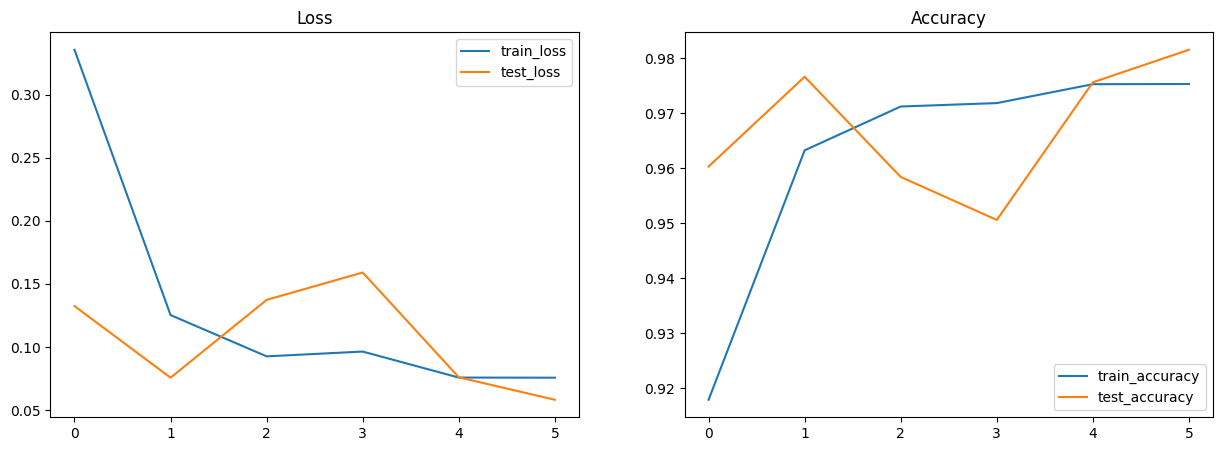

In [27]:
metrics_history = {
    "train_loss": [],
    "test_loss": [],
    "train_accuracy": [],
    "test_accuracy": [],
}

for step, batch in enumerate(train_ds.as_numpy_iterator()):
    # Run the optimization for one step and make a stateful update to the following:
    # - The train state's model parameters
    # - The optimizer state
    # - The training loss and accuracy batch metrics
    model.train()  # switch to train
    train_step(model=model, optimizer=optimizer, metrics=metrics, batch=batch)

    if step > 0 and (step % eval_every == 0 or step == train_steps - 1):
        for metric, value in metrics.compute().items():  # Compute the metrics.
            metrics_history[f"train_{metric}"].append(value)  # Record the metrics.
        metrics.reset()

        model.eval()  # swith to eval mode
        for test_batch in test_ds.as_numpy_iterator():
            eval_step(model, metrics, test_batch)


        for metric, value in metrics.compute().items():  # Compute the metrics.
            metrics_history[f"test_{metric}"].append(value)  # Record the metrics.
        metrics.reset()

        clear_output(wait=True)
        fit, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        ax1.set_title('Loss')
        ax2.set_title('Accuracy')
        for dataset in ('train', 'test'):
            ax1.plot(metrics_history[f'{dataset}_loss'], label=f'{dataset}_loss')
            ax2.plot(metrics_history[f'{dataset}_accuracy'], label=f'{dataset}_accuracy')
        ax1.legend()
        ax2.legend()
        plt.show()

## Perform inference on the test set

Create a jit-compiled model inference function (with nnx.jit) - pred_step - to generate predictions on the test set using the learned model parameters. This will enable you to visualize test images alongside their predicted labels for a qualitative assessment of model performance.

In [28]:
model.eval()
# We call .eval() before inference so Dropout is disabled and BatchNorm uses stored running stats.
# It is used during inference to suppress gradients and ensure deterministic, resource-efficient output.

@nnx.jit
def pred_step(model: CNN, batch):
    logits = model(batch["image"])
    return logits.argmax(axis=1)

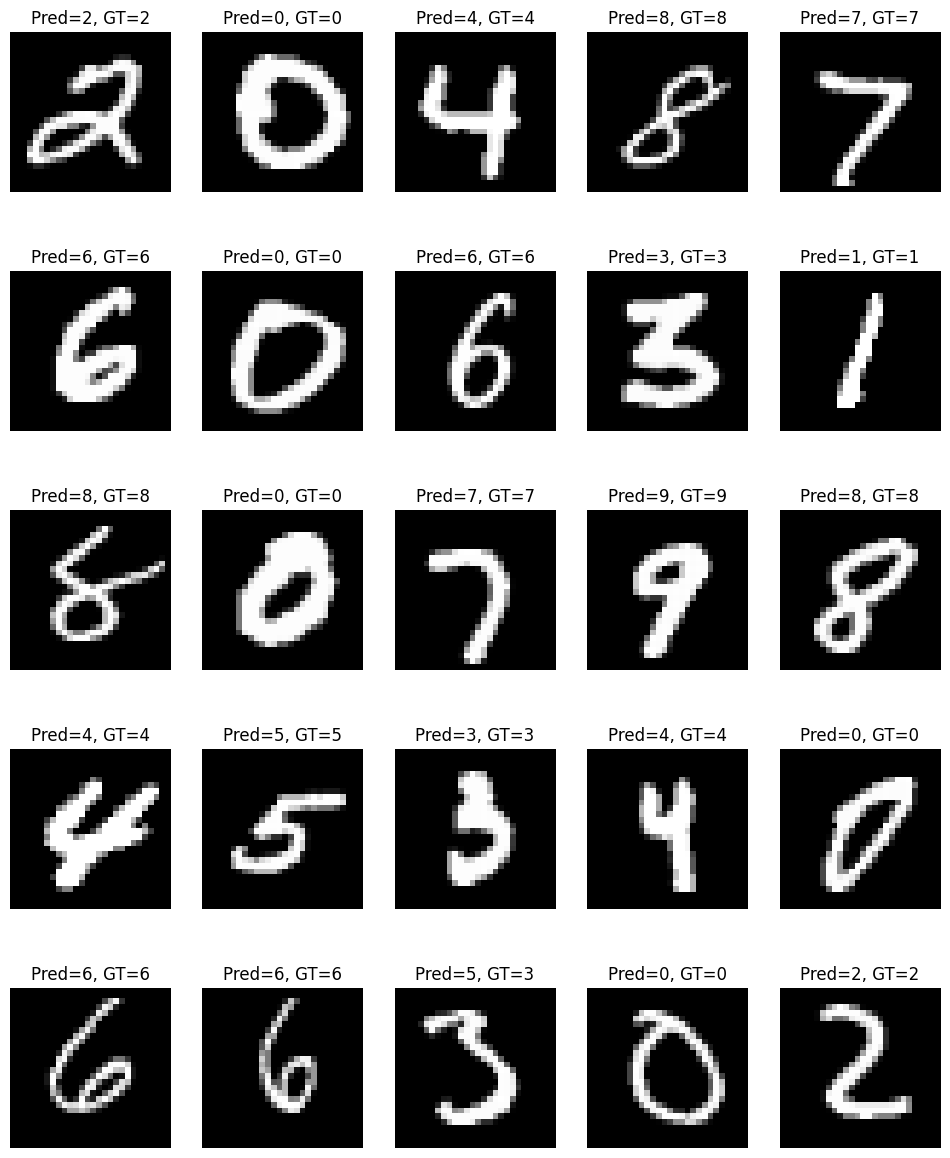

In [32]:
test_batch = test_ds.as_numpy_iterator().next()
pred = pred_step(model, test_batch)

fig, axs = plt.subplots(5, 5, figsize=(12, 15))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(test_batch["image"][i, ..., 0], cmap="gray")
    ax.set_title(f"Pred={pred[i]}, GT={test_batch["label"][i]}")
    ax.axis("off")

**Congratulations!** You have learned how to use Flax NNX to build and train a simple classification model end-to-end on the MNIST dataset.